# Sentiment Analysis

# PART 4

## Installs, Imports and Paths

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!pip install -U scikit_learn
!pip install -U nltk
!pip install -U datasets
!pip install --upgrade tensorflow
!pip install scipy
!pip install --upgrade scikeras
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: scikit_learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.2 MB/s 

In [3]:
import numpy as np
import pandas as pd
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
import nltk
import tensorflow as tf
import os
import keras
import urllib.request, zipfile
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import FastText
from tensorflow.keras.layers import Layer
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Masking, Embedding, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.constraints import MaxNorm
from datasets import load_dataset
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from nltk import sent_tokenize, word_tokenize, pos_tag
from sklearn.model_selection import learning_curve, GridSearchCV
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from google.colab import files
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, MaxPooling1D, concatenate

stemmer = WordNetLemmatizer()
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
if not os.path.exists('./Sentiment-Analysis'):
  os.makedirs('./Sentiment-Analysis')
os.chdir('./Sentiment-Analysis')

## Data Preprocessing

### Dataset Loading

In [27]:
def remove(text, polarity, n):
    for _ in range(int(len(text)*n)):
        number = random.randrange(0,len(text))
        text.pop(number)
        polarity.pop(number)
    return

#importing the dataset
tweets = load_dataset("tweet_eval",'sentiment')

#create train/dev/test sets 
train = tweets['train']
dev = tweets['validation']
test = tweets['test']

x_train = train['text']
x_val = dev['text'] 
x_test = test['text']

y_train = train['label'] 
y_val = dev['label']
y_test = test['label']

#removing big parts because of too many data
#remove(x_train, y_train, 0.95)
#remove(x_val, y_val, 0.95)
#remove(x_test, y_test, 0.95)

print("Training Data Size: ", len(x_train))
print("Evaluation Data Size: ", len(x_val))
print("Test Data Size: ", len(x_test))

  0%|          | 0/3 [00:00<?, ?it/s]

Training Data Size:  45615
Evaluation Data Size:  2000
Test Data Size:  12284


### Label Binarization

In [28]:
lb = LabelBinarizer()
target_list_dict = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
target_list_name = ['Positive', 'Neutral', 'Negative']
target_list = ['0', '1', '2']

y_train_1_hot = lb.fit_transform([target_list[x] for x in y_train])
y_val_1_hot = lb.transform([target_list[x] for x in y_val])
y_test_1_hot = lb.transform([target_list[x] for x in y_test])

print('y_train_1_hot[0]: {}'.format(y_train_1_hot[0]))

y_train_1_hot[0]: [0 0 1]


### Load Embeddings

In [7]:
if not os.path.exists('./embeddings'):
  os.makedirs('./embeddings')

urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip', './embeddings/wiki-news-300d-1M.vec.zip')
zip_ref = zipfile.ZipFile('./embeddings/wiki-news-300d-1M.vec.zip', 'r')
zip_ref.extractall('./embeddings')
zip_ref.close()

embs_path = './embeddings/wiki-news-300d-1M.vec'
embeddings = KeyedVectors.load_word2vec_format(embs_path, binary=False)

### Truncate sentences

In [29]:
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = embeddings.vectors.shape[1]

def truncate_sentences(x_train, MAX_LENGTH):
    truncated_sentences = []
    for sentence in x_train:
        truncated_sentences.append(sentence[:MAX_LENGTH])
    return truncated_sentences

x_train_trunc = truncate_sentences(x_train, MAX_SEQUENCE_LENGTH)
x_val_trunc = truncate_sentences(x_val, MAX_SEQUENCE_LENGTH)
x_test_trunc = truncate_sentences(x_test, MAX_SEQUENCE_LENGTH)

### Create tuples and count words

In [30]:
# Create tuples of x,y
def get_sentences(x, y):
  train_sentences = []
  for i in range(len(x)):
    train_sentences.append((x[i], y[i]))
  return train_sentences

train_sentences = get_sentences(x_train_trunc, y_train)
val_sentences = get_sentences(x_val_trunc, y_val)
test_sentences = get_sentences(x_test_trunc, y_test)

In [31]:
MAX_WORDS = 18000

# Initialize the word_index dictionary with an index for the pad token and an index for the oov words
word_index = {'padding': 0, 'oov': 1}

# Flatten the list of tuples into a list of words
all_words = [word for sentence in x_train for word in sentence.split()]

# Count the number of occurrences of each word
word_counts = Counter(all_words)
print(word_counts)
# Keep only some of the words
def select_top_n_words(word_counts, n):
    # Create a new dictionary with 'pad' and 'oov' as keys and their corresponding values
    new_word_counts = {'padding': 0, 'oov': 1}
    # Sort the word counts dictionary by values in descending order
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    # Add the top n words (excluding 'pad' and 'oov') to the new dictionary
    for word, count in sorted_word_counts[:n]:
        new_word_counts[word] = count
    # Reassign the values of the new dictionary to be sequential integers starting from 2
    for i, (word, count) in enumerate(new_word_counts.items()):
        new_word_counts[word] = i

    return new_word_counts

word_index = select_top_n_words(word_counts, MAX_WORDS)
print(word_index)

Counter({'the': 34587, 'to': 20490, '@user': 16830, 'in': 12896, 'on': 12311, 'a': 12011, 'and': 11797, 'of': 10581, 'I': 10555, 'for': 9543, 'is': 9069, 'with': 7271, 'be': 6967, 'at': 6820, 'you': 6707, 'may': 5518, 'it': 5006, 'have': 4128, 'that': 4055, 'tomorrow': 4039, 'my': 3927, 'was': 3347, 'will': 3327, 'but': 3298, 'just': 3214, 'this': 3098, 'going': 2746, 'The': 2612, '-': 2591, 'from': 2565, 'he': 2547, 'out': 2483, 'not': 2480, 'see': 2402, 'me': 2373, 'about': 2345, '1st': 2337, 'are': 2333, 'all': 2291, 'like': 2226, 'as': 2170, 'so': 2118, 'up': 2081, 'get': 1971, "I'm": 1953, 'day': 1898, 'his': 1895, 'by': 1851, '&amp;': 1774, 'if': 1755, '2nd': 1696, 'time': 1655, 'Friday': 1627, 'we': 1625, 'has': 1610, 'go': 1596, 'night': 1544, 'your': 1516, 'Sunday': 1513, 'or': 1509, 'can': 1418, 'one': 1394, 'an': 1356, 'when': 1319, 'i': 1304, 'want': 1276, '3rd': 1276, 'Saturday': 1221, "it's": 1214, 'new': 1213, 'game': 1197, 'know': 1181, 'they': 1167, 'make': 1156, 'do':

### Generate Embedding matrix

In [32]:
# Get the embedding matrix
vocab_size = len(word_index)  # +1 for OOV, +1 for pad
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
# Add OOV and pad vectors
embedding_matrix[0] = np.random.uniform(-0.25, 0.25, EMBEDDING_DIM)  # OOV vector
embedding_matrix[1] = np.zeros(embeddings.vectors.shape[1])  # pad vector
# Add pre-trained embeddings for known words
for word, i in word_index.items():
  if i > MAX_WORDS:
          continue
  try:
      embedding_matrix[i] = embeddings[word]
  except:
      pass

### Produce x,y to build the model

In [33]:
# Our current dictionary includes 0 as a category (positive), we want to change that so we don't mix it with the padding
def alter_mapping(my_dict):
    new_dict = {}
    encoded_classes = []
    for key in my_dict: # start from 1 so we don't mix classes with pads
        encoded_classes.append(my_dict[key] + 1)
        new_dict[key] = my_dict[key] + 1

    return encoded_classes, new_dict

# If status = add it means that we convert (0,1,2) to (1,2,3) if it is subtract the opposite
def alter_labels(data, status):
  temp = []
  for i in range(len(data)):
    if status == 'add':
      temp.append(data[i]+ 1)
    if status == 'subtract':
      temp.append(data[i] - 1)
  return temp

encoded_classes, new_dict = alter_mapping(target_list_dict)

y_train_1_hot = lb.fit_transform([encoded_classes[x] for x in y_train])
y_val_1_hot = lb.transform([encoded_classes[x] for x in y_val])
y_test_1_hot = lb.transform([encoded_classes[x] for x in y_test])

In [34]:
# Using the dictionary we built before, we convert the data to sequences
def to_sequence(data):
  lem_sents = []
  for sentence in data:
    temp_sentence = []
    for word in sentence.split():
      if(word in word_index):
        temp_sentence.append(word_index[word])
      else:
        temp_sentence.append(word_index['oov'])
    lem_sents.append(temp_sentence)
  return lem_sents

train_seqs = to_sequence(x_train_trunc)
val_seqs = to_sequence(x_val_trunc)
test_seqs = to_sequence(x_test_trunc)

train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
val_data = pad_sequences(val_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

## CNN

In [35]:
# Create and train a CNN model with trigram filters

pooled_convs = []
filter_sizes = [2,3,4]

with tf.device('/device:GPU:0'):
  inputs = keras.Input((train_data.shape[1],),)
  mask = keras.layers.Masking(mask_value=0)(inputs) # Mask the pads
  embeddings_layer = keras.layers.Embedding(input_dim = MAX_WORDS + 2, output_dim = EMBEDDING_DIM,  input_length = MAX_SEQUENCE_LENGTH,
                                          weights = [embedding_matrix], mask_zero = True, trainable = True)(mask)
  x = keras.layers.Dropout(0.5)(embeddings_layer)
  x = keras.layers.BatchNormalization()(x) # Normalize
  # Multi-filter CNN
  for n_gram in filter_sizes:
      # n-gram convolutions with padding
      convs = Conv1D(filters= 128, kernel_size=n_gram, strides=1, 
                     padding="same", activation='relu', 
                     name='{}-gram_Convolutions'.format(n_gram))(x)
      # Max-Pooling over time
      pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs))
    
  # Concatenation of filters form all window sizes
  concat =  concatenate(pooled_convs)
  concat = Dropout(rate=0.5)(concat)
  outputs = Dense(y_train_1_hot.shape[1], activation='softmax')(concat)
  cnn_model = keras.Model(inputs, outputs)
  print(cnn_model.summary())
  
  cnn_model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.01),
                metrics=['accuracy'])


  if not os.path.exists('./my_CNN_checkpoint'):
    os.makedirs('./my_CNN_checkpoint')

  cnn_callbacks = [
      keras.callbacks.ModelCheckpoint(
          './my_CNN_checkpoint/weights.hdf5',
          monitor='val_accuracy', 
          mode='max', 
          verbose=2,
          save_best_only=True,
          save_weights_only=True)
  ]

  history = cnn_model.fit(train_data, y_train_1_hot,
                batch_size = 128,
                epochs = 10,
                callbacks = cnn_callbacks,
                validation_data = (val_data, y_val_1_hot),
                shuffle = True)
  
  print(f"Test Accuracy: {cnn_model.evaluate(test_data, y_test_1_hot)[1]:.5f}")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 masking_3 (Masking)            (None, 200)          0           ['input_4[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 200, 300)     5400600     ['masking_3[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 200, 300)     0           ['embedding_3[0][0]']            
                                                                                            

### Learning Curves

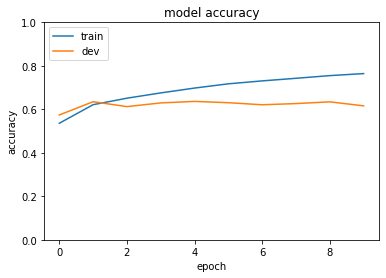

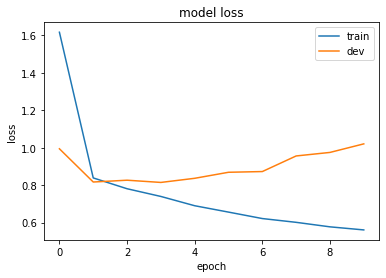

In [36]:
%matplotlib inline

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.ylim(0,1)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

### Model Assessment

In [37]:
def reverse_dict(dictionary):
    reversed_dict = {}
    for key, value in dictionary.items():
        reversed_dict[value] = key
    return reversed_dict

reversed_dictionary = reverse_dict(new_dict)

In [38]:
# Change labels from 1-hot to 1,2,3
def shift(y):
  new_y = []
  for item in y:
    count = 0
    for position in item:
      if position == 1:
        new_y.append(count + 1)
      count += 1
  return new_y

In [39]:
def my_classification_report(x, y, model):
  y_true = []
  y_pred = model.predict(x, verbose=1).argmax(-1)
  y_pred_flat = [item for item in y_pred] # flatten y_pred
  y_pred = alter_labels(y_pred_flat, 'add') # change labels from 0,1,2 to 1,2,3
  y_true = shift(y) # Change labels from 1-hot to 1,2,3

  return y_true, y_pred

In [40]:
with tf.device('/device:GPU:0'):

  pooled_convs = []
  filter_sizes = [2,3,4]

  inputs = keras.Input((train_data.shape[1],),)
  mask = keras.layers.Masking(mask_value=0)(inputs) # Mask the pads
  embeddings_layer = keras.layers.Embedding(input_dim = MAX_WORDS + 2, output_dim = EMBEDDING_DIM,  input_length = MAX_SEQUENCE_LENGTH,
                                          weights = [embedding_matrix], mask_zero = True, trainable = True)(mask)
  x = keras.layers.Dropout(0.5)(embeddings_layer)
  x = keras.layers.BatchNormalization()(x) # Normalize
  # Multi-filter CNN
  for n_gram in filter_sizes:
      # n-gram convolutions with padding
      convs = Conv1D(filters= 128, kernel_size=n_gram, strides=1, 
                     padding="same", activation='relu', 
                     name='{}-gram_Convolutions'.format(n_gram))(x)
      # Max-Pooling over time
      pooled_convs.append(GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs))
    
  # Concatenation of filters form all window sizes
  concat =  concatenate(pooled_convs)
  concat = Dropout(rate=0.5)(concat)
  outputs = Dense(y_train_1_hot.shape[1], activation='softmax')(concat)
  cnn_model = keras.Model(inputs, outputs)
  print(cnn_model.summary())

  # Load weights from the pre-trained model
  cnn_model.load_weights("./my_CNN_checkpoint/weights.hdf5")
  cnn_model.compile(
      loss='categorical_crossentropy',
      optimizer=Adam(learning_rate=0.01),
      metrics=["accuracy"]
      )
  
y_train_true, y_train_pred_CNN = my_classification_report(train_data, y_train_1_hot, cnn_model)
m_train_f1_score = f1_score(y_train_true, y_train_pred_CNN, average = 'macro')
print("Train f1-score: {:.2f}% \n".format(m_train_f1_score*100))

y_val_true, y_val_pred_CNN = my_classification_report(val_data, y_val_1_hot, cnn_model)
m_val_f1_score = f1_score(y_val_true, y_val_pred_CNN, average = 'macro')
print("Evaluation f1-score: {:.2f}% \n".format(m_val_f1_score*100))

y_test_true, y_test_pred_CNN = my_classification_report(test_data, y_test_1_hot, cnn_model)
m_test_f1_score = f1_score(y_test_true, y_test_pred_CNN, average = 'macro')
print("Test f1-score: {:.2f}% \n".format(m_test_f1_score*100))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 masking_4 (Masking)            (None, 200)          0           ['input_5[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 200, 300)     5400600     ['masking_4[0][0]']              
                                                                                                  
 dropout_4 (Dropout)            (None, 200, 300)     0           ['embedding_4[0][0]']            
                                                                                            

### Precision, Recall, AUC, ROC-AUC

In [41]:
def errorCheck(y_true, y_pred):

  # Find the unique classes in y_true and y_pred
  unique_classes = np.unique(np.concatenate((y_true, y_pred)))

  # Find the classes present in y_true but not in y_pred
  missing_classes_y_pred = unique_classes[np.in1d(unique_classes, y_true) & ~np.in1d(unique_classes, y_pred)]

  # Find the classes present in y_pred but not in y_true
  missing_classes_y_true = unique_classes[np.in1d(unique_classes, y_pred) & ~np.in1d(unique_classes, y_true)]

  # Calculate the sample size before modifying y_pred and y_true and my_max to know which has the extra class
  if len(y_pred) > len(y_true):
    my_max = y_pred
  else:
    my_max = y_true

  sample_size = max(len(y_pred), len(y_true))

  # Modify y_pred to include all the classes present in y_true
  for c in missing_classes_y_pred:
      y_pred = np.append(y_pred, c)

  # Modify y_true to include all the classes present in y_pred
  for c in missing_classes_y_true:
      y_true = np.append(y_true, c)

  y_pred_onehot = np.eye(len(unique_classes))[y_pred[:sample_size]]
  y_true_onehot = np.eye(len(unique_classes))[y_true[:sample_size]]

  return y_true, y_true_onehot, y_pred, y_pred_onehot, my_max

In [42]:
def calculate_CNN_Results(x, y_true, y_pred, model):
  y_pred_enc = alter_labels(y_pred, 'subtract') # 0,1,2
  y_true_enc = alter_labels(y_true, 'subtract') # 0,1,2

  train_precision_score = precision_score(y_true_enc, y_pred_enc, average = None)
  train_recall_score = recall_score(y_true_enc, y_pred_enc, average = None)
  train_f1_score = f1_score(y_true_enc, y_pred_enc, average = None)


  m_train_precision_score = precision_score(y_true_enc, y_pred_enc, average = 'macro')
  m_train_recall_score = recall_score(y_true_enc, y_pred_enc, average = 'macro')
  m_train_f1_score = f1_score(y_true_enc, y_pred_enc, average = 'macro')

  y_pred_onehot = np.eye(len(np.unique(y_pred_enc)))[y_pred_enc]

  # One-hot encode the true class labels
  y_true_onehot = np.eye(len(np.unique(y_true_enc)))[y_true_enc]


  m_train_roc_auc_score = roc_auc_score(y_true_onehot, y_pred_onehot, multi_class= 'ovr', average = 'macro')

  # auc calculation is a bit more messy

  classes = [0, 1, 2]
  train_roc_auc_score = {}
  for i in range(len(classes)):
      c = classes[i]
      # Prepares an auxiliar dataframe to help with the plots
      df_x = pd.DataFrame (x) # convert list to a dataframe
      y_proba = model.predict(x, verbose = 0) # calculate the probabilities
      df_aux = df_x.copy()
      df_aux['class'] = [1 if y == c else 0 for y in y_true_enc]
      df_aux['prob'] = y_proba[:, i]
      df_aux = df_aux.reset_index(drop = True)
    
      # Calculates the ROC AUC OvR
      train_roc_auc_score[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

  table = [['    ', 'Precision', 'Recall', 'F1', 'AUC', 'Macro-Precision', 'Macro-Recall', 'Macro-F1', 'Macro-AUC'], 
        ['Positive', round(train_precision_score[0], 3), round(train_recall_score[0], 3), round(train_f1_score[0], 3), round(train_roc_auc_score[0], 3), '-', '-', '-', '-'],
        ['Neutral', round(train_precision_score[1], 3), round(train_recall_score[1], 3), round(train_f1_score[1], 3), round(train_roc_auc_score[1], 3), '-', '-', '-', '-'],
        ['Negative', round(train_precision_score[2], 3), round(train_recall_score[2], 3), round(train_f1_score[2], 3), round(train_roc_auc_score[2], 3), '-', '-', '-', '-'],
        ['Total', '-', '-','-','-', round(m_train_precision_score, 3), round(m_train_recall_score, 3), round(m_train_f1_score, 3), round(m_train_roc_auc_score, 3)]]

  print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [43]:
print("CNN ---------------------------------------------------------------------------------------------------------\n")

print("The training results: \n")
calculate_CNN_Results(train_data, y_train_true, y_train_pred_CNN, cnn_model)

print("The evaluation results: \n")
calculate_CNN_Results(val_data, y_val_true, y_val_pred_CNN, cnn_model)

print("The test results: \n")
calculate_CNN_Results(test_data, y_test_true, y_test_pred_CNN, cnn_model)

CNN ---------------------------------------------------------------------------------------------------------

The training results: 

╒══════════╤═════════════╤══════════╤═══════╤═══════╤═══════════════════╤════════════════╤════════════╤═════════════╕
│          │ Precision   │ Recall   │ F1    │ AUC   │ Macro-Precision   │ Macro-Recall   │ Macro-F1   │ Macro-AUC   │
╞══════════╪═════════════╪══════════╪═══════╪═══════╪═══════════════════╪════════════════╪════════════╪═════════════╡
│ Positive │ 0.834       │ 0.537    │ 0.653 │ 0.938 │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Neutral  │ 0.682       │ 0.918    │ 0.783 │ 0.89  │ -                 │ -              │ -          │ -           │
├──────────┼─────────────┼──────────┼───────┼───────┼───────────────────┼────────────────┼────────────┼─────────────┤
│ Negative │ 0.899       │ 0.666    │ 0

### Hyper Parameter Tuning for the CNN

In [45]:
with tf.device('/device:GPU:0'):
  
  def nn_model(optimizer = 'Adam', dropout = 0.5, activation = 'relu', trainable = True, filters = 128, learning_rate = 0.01, batch_size = 256):
    inputs = keras.Input((train_data.shape[1],),)
    mask = keras.layers.Masking(mask_value=0)(inputs) # Mask the pads
    embeddings_layer = keras.layers.Embedding(input_dim = MAX_WORDS + 2, output_dim = EMBEDDING_DIM,  input_length = MAX_SEQUENCE_LENGTH,
                                            weights = [embedding_matrix], mask_zero = True, trainable = True)(mask)
    x = keras.layers.Dropout(rate = 0.5)(embeddings_layer)
    x = keras.layers.BatchNormalization()(x) # Normalize
    # add a stack of convolution layers
    x = keras.layers.Conv1D(filters= 128, kernel_size= 3, activation='relu', padding='same')(x)
    x = keras.layers.Conv1D(filters= 128, kernel_size= 3, activation='relu', padding='same')(x)
    x = keras.layers.Conv1D(filters= 128, kernel_size= 3, activation='relu', padding='same')(x)
    x = keras.layers.Conv1D(filters= 128, kernel_size= 3, activation='relu', padding='same')(x)
    x = keras.layers.Conv1D(filters= 128, kernel_size= 3, activation='relu', padding='same')(x)
    # max pooling
    x = keras.layers.GlobalMaxPooling1D()(x)
    # add dropout
    x = keras.layers.Dropout(rate = 0.5)(x)
    # add dense layer
    x = keras.layers.Dense(64, activation = 'relu')(x)
    # output layer
    outputs = keras.layers.Dense(y_train_1_hot.shape[1], activation = 'softmax')(x)
    cnn_model = keras.Model(inputs, outputs)
    print(cnn_model.summary())

    # Load weights from the pre-trained model
    #cnn_model.load_weights("./my_CNN_checkpoint/weights.hdf5")
    cnn_model.compile(optimizer = tune_lr(optimizer = optimizer, learning_rate = learning_rate), loss='categorical_crossentropy', metrics= ['accuracy'])

    return cnn_model


  def tune_lr(optimizer, learning_rate):
    optimizerDict = {'Adam': Adam(learning_rate=learning_rate), 'SGD': SGD(learning_rate=learning_rate), 'RMSprop': RMSprop(learning_rate=learning_rate)}
    result = optimizerDict[optimizer]
    
    return result

  batch_size = [64, 128, 256]
  filters = [64, 128, 256]
  learning_rate = [0.001, 0.01, 0.1]
  activation = ['relu', 'tanh', 'softmax']
  optimizer = ['SGD', 'Adam', 'RMSprop']
  trainable = [True, False]
  dropout = [0.2, 0.4, 0.5]
  param_grid = dict(optimizer = optimizer, dropout = dropout, trainable = trainable, activation = activation, filters = filters, learning_rate = learning_rate, batch_size= batch_size)
  clf = KerasClassifier(build_fn = nn_model, epochs = 5, verbose = 2, dropout = dropout, trainable = trainable, activation = activation,
                        filters = filters, learning_rate = learning_rate)
  cnn_model = RandomizedSearchCV(estimator= clf, cv = 5, param_distributions = param_grid, n_jobs=-1,verbose = 2,random_state=1234)
  cnn_model.fit(val_data, y_val_1_hot)

print("Best estimator \n", cnn_model.best_estimator_)
print("Best score \n", cnn_model.best_score_)
print("Best params \n", cnn_model.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 masking_5 (Masking)         (None, 200)               0         
                                                                 
 embedding_5 (Embedding)     (None, 200, 300)          5400600   
                                                                 
 dropout_6 (Dropout)         (None, 200, 300)          0         
                                                                 
 batch_normalization_3 (Batc  (None, 200, 300)         1200      
 hNormalization)                                                 
                                                                 
 conv1d (Conv1D)             (None, 200, 128)          115328   

/usr/local/lib/python3.8/dist-packages/scikeras/wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


None
Epoch 1/5
32/32 - 8s - loss: 9556.1084 - accuracy: 0.3980 - 8s/epoch - 243ms/step
Epoch 2/5
32/32 - 4s - loss: 32.0573 - accuracy: 0.4340 - 4s/epoch - 116ms/step
Epoch 3/5
32/32 - 2s - loss: 420.0208 - accuracy: 0.4100 - 2s/epoch - 72ms/step
Epoch 4/5
32/32 - 1s - loss: 4.1619 - accuracy: 0.4205 - 1s/epoch - 42ms/step
Epoch 5/5
32/32 - 1s - loss: 2.0268 - accuracy: 0.4265 - 1s/epoch - 37ms/step
Best estimator 
 KerasClassifier(
	model=None
	build_fn=<function nn_model at 0x7fadf8268b80>
	warm_start=False
	random_state=None
	optimizer=Adam
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=5
	dropout=0.4
	trainable=False
	activation=softmax
	filters=256
	learning_rate=0.1
	class_weight=None
)
Best score 
 0.43499999999999994
Best params 
 {'trainable': False, 'optimizer': 'Adam', 'learning_rate': 0.1, 'filters': 256, 'dropout': 0.4, 'batch_size': 64, 'activation': 'softmax'}
